In [17]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages # A reducer function
from langchain_openai import ChatOpenAI, AzureChatOpenAI
from pydantic import BaseModel
from dotenv import load_dotenv
from typing import Annotated
from databricks_langchain import ChatDatabricks
import os
from client import AzureAIClient
from IPython.display import Image, display
import gradio as gr
import requests

In [11]:
load_dotenv(override=True)

True

In [3]:
# Create a simple state
from pydantic import BaseModel


class State(BaseModel):
    messages: Annotated[list, add_messages]

In [4]:
# Get llms
llm_db = ChatDatabricks(endpoint="databricks-claude-3-7-sonnet", max_tokens=1000)

llm_az = AzureChatOpenAI(
    api_version="2024-12-01-preview",
    azure_ad_token_provider=AzureAIClient().token_provider,
    # azure_deployment="gpt-4o"
    azure_deployment="o4-mini"
)

2025-07-05 18:59:42.694 | SUCCESS  | client:_get_token_provider:41 - Successfully initialized Azure Credentials!!


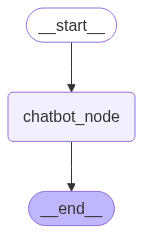

In [5]:
# Build a graph
graph_builder = StateGraph(state_schema=State)

# Create node
def chatbot_node(old_state: State) -> State:
    response = llm_az.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot_node", chatbot_node)

# Create Edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Create the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# Create a simple chat interface using gradio
def chat(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state)
    print(result)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='f4febdcb-ec4c-4753-92fd-34c8f56680c5'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 8, 'total_tokens': 36, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'id': 'chatcmpl-BpyenCKVJAf7iU9PDq0OggT66lzJQ', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}]

### Making a more functional langgraph agentic workflow

In [8]:
# Get a nice googler serper fucntion
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the current date?")

'Today, July 5th , is day 186 of 365 total days in 2025. What is Today\'s Date in Numbers? Today\'s date in numbers is: MM-DD-YYYY: 07-05-2025; DD-MM-YYYY: ... Find out the current day, date of today, local time and week number. The weekday today is Saturday and today\'s date is. July 05, 2025. Today\'s ... Welcome to the world\'s top site for time, time zones, and astronomy. Organize your life with free online info and tools you can rely on. No sign-up needed. This page includes the following information: Today\'s date: day of week, month, day, year. Current time: hours, minutes, seconds. Saturday, July 05, 2025 · Today\'s day number is: 186 (of 365 / year 2025 is a leap year) · There are 179 days remaining in this year 2025. · The current week ... Today Saturday, July 5, 2025 is ... Day of the year is a number between 1 and 365 (in 2025), January 1 is day 1. After today 179 days are remaining in this year. ... Details about today\'s date with count of days, weeks, and months, Sun and

In [50]:
# Create a new tool for the agent
from langchain.agents import Tool

tool_search = Tool(
    name="google_search",
    func=serper.run,
    description="Useful for when you need more information from an online search"
)

In [51]:
tool_search.run("Who is the current president of India?")

'Droupadi Murmu'

In [52]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [53]:
tool_push = Tool(
    name="push_notification",
    func=push,
    description="Useful for sending push notifications to the user"
)
tool_push.invoke("Hi there this is from pushover!")

In [54]:
tools = [tool_search, tool_push]
llm_az_tools = llm_az.bind_tools(tools)

In [55]:
graph_builder2 = StateGraph(state_schema=State)

# Nodes again
def chatbot_node(old_state: State) -> State:
    response = llm_az_tools.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder2.add_node("chatbot_node", chatbot_node)
graph_builder2.add_node("tools", ToolNode(tools=tools))

# Add edges with conditions
graph_builder2.add_conditional_edges("chatbot_node", tools_condition, "tools")
graph_builder2.add_edge("tools", "chatbot_node")

graph_builder2.add_edge(START, "chatbot_node")


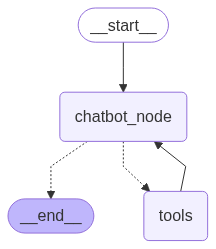

In [56]:
# Compile the graph
graph2 = graph_builder2.compile()
display(Image(graph2.get_graph().draw_mermaid_png()))

In [ ]:
# Create a simple chat interface using gradio
def invoke_graph(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph2.invoke(initial_state)
    print(result)
    return result["messages"][-1].content

gr.ChatInterface(invoke_graph, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi there', additional_kwargs={}, response_metadata={}, id='a3a257ad-4d77-472e-bec5-9d2c9f3f7217'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 88, 'total_tokens': 116, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'id': 'chatcmpl-BpzfWiQxYf4kGwFWIFf9meQCyjBgG', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}